# Calculating Copper - Jack Maughan

The ExploreSA Gawler Challenge was designed to find and apply new approaches to mineral exploration, using state geology and geophysics data.  The following notebook is a part of the series, __'Calculating Copper'__ and contains my thinking, processing and results for the challenge, with a idea of recreating a reproducible workflow for similar mineral exploration problems. 

![Title](https://docs.google.com/uc?export=download&id=1goFsreNqBipsuyFEOwi6cGgrpWwARCEt)

#### 1. Geology Forever - Background Information
#### 2. Hair and Makeup - Target Variable and Features
#### 3. Suit up - Compiling Dataframe and Feature Statistics
### *4. My Friend Robot - Machine Learning Model Creation*
#### 5. Gold Rush - Model Validation and Results
#### 6. Extra Extra - Unsupervised Learning and CoDa on Soil Geochemistry

# My Friend Robot

The next notebook in the Calculating Copper series, __My Friend Robot__, looks at building several machine learning models on our dataset and assessing their performance. Based on these performances, we'll tune the hyperparameters of each model, asses the fit of each model (overfitting vs underfitting) and then apply the models to the remaining unknown areas across the craton. Our first step, as always, is to load in the python libraries required for this notebook.

In [2]:
#Loading in python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Patch
import seaborn as sns

from mlxtend.preprocessing import shuffle_arrays_unison
from mlxtend.plotting import plot_learning_curves
from yellowbrick.model_selection import LearningCurve

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from PIL import Image
import rasterio as rio

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

/Users/jackmaughan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/jackmaughan/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the fol

## Data Preperation

In the __Suit Up__ notebook we decided to remove the feature 'SA_RESIDUAL' from our dataset as it was so similar to the original gravity image. To get our data ready for machine learning we'll first load it in, remove the unnecessary features and then split it into our target variable, learning features and zones feature.

In [3]:
#Reading in 250m examples
df = pd.read_csv('AOI_250m.csv')

In [4]:
#Sorting columns and checking the dataframe shape
df = df.sort_values('Zones')
df.shape

(745, 14)

In [5]:
#Splitting data into features, areas of interests and zones
X = df.drop(['Unnamed: 0', 'Areas_of_Interest', 'Zones', 'SA_RESIDUAL'], axis=1)
Y = df['Areas_of_Interest']
Z = df['Zones']

In [6]:
X.describe()

,Log_Distance_to_Archaean_Contact,Log_Distance_to_Faults,Log_GCAS_RTP_1VD,Log_GCAS_RTP_2VD,Log_SA_GRAV_Slope,MT_20000m,MT_50000m,SA_GRAV,SA_GRAV_1VD,SA_TMI_RTP
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,7.553770,7.229515,2.727697,0.742243,-2.542817,2.748055,3.004303,-16.269027,0.002080,867.616947
std,1.574788,1.472296,1.269778,1.330510,0.854361,0.826780,0.706024,17.427928,0.004100,2007.827890
min,3.438434,3.668614,-1.319633,-3.680342,-5.748983,0.586873,0.393551,-52.397890,-0.005517,-1359.798000
25%,6.552088,6.272774,1.903265,-0.069302,-3.085304,2.133033,2.574053,-30.711450,-0.000684,-135.219090
50%,7.801685,7.382827,2.864508,1.087413,-2.558735,2.839093,3.048487,-13.934030,0.000849,229.825070
75%,8.784880,8.240850,3.817674,1.767631,-1.971683,3.559272,3.560178,-4.843235,0.003300,1013.107100
max,10.514371,10.674739,4.486279,3.015299,-0.533133,4.439942,4.442378,36.345814,0.021010,15363.149000


We can see our data is now in a format that we can use for machine learning. As we also mentioned in the previous notebook, we are going to use Sci-Kits Learns GroupShuffleSplit function to cross validate our data across different zones of the Gawler Craton. We do this to reduce the affects of spatial correlation in areas. As our dataset is quite small and only contains 745 instances, we can get a bit wild with the number of cross validation folds, so we'll create 50 cross validation splits to ensure we are getting a good representation of the model performance. This is also important (as we'll see shortly) because not all of the zones contain the same amount of data (leading to uneven train/test splits) and the data within those zones are not evenly split between barren and mineralised data samples. In the next cell we'll look at how the cross validation folds were selected according to their zones.

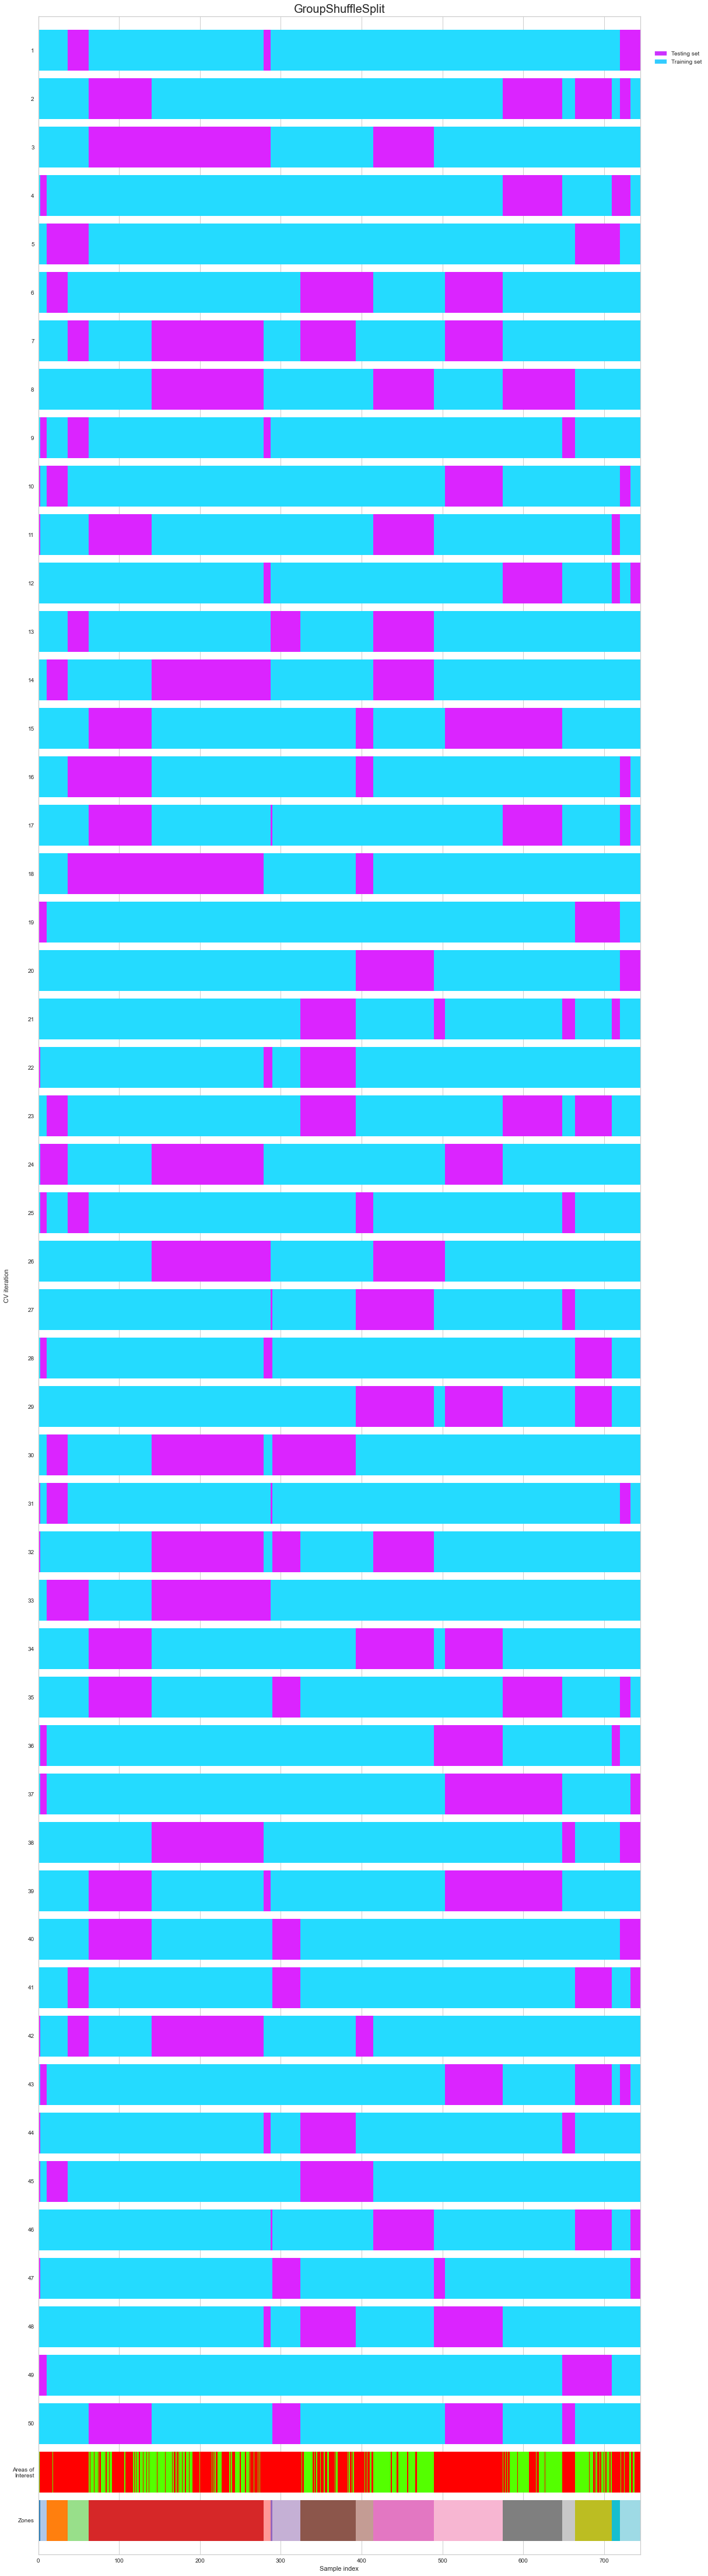

In [7]:
#Formatting the plot
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots()


#Creating our group shuffle split for the data
gss = GroupShuffleSplit(n_splits=50, train_size=0.8, random_state=4)

#Select number of splits
n_splits=50

# Generate the training/testing visualizations for each CV split
for ii, (tr, tt) in enumerate(gss.split(X=X, y=Y, groups=Z)):
    # Fill in indices with the training/test groups
    indices = np.array([np.nan] * len(X))
    indices[tt] = 1
    indices[tr] = 0

    # Visualize the results
    ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=70, cmap=plt.cm.cool,
                   vmin=-.2, vmax=1.2)

# Plot the data classes and groups at the end
ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=Y, marker='_', lw=70, cmap=plt.cm.prism)

ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=Z, marker='_', lw=70, cmap=plt.cm.tab20)
    
# Formatting
yticklabels = list(range(1, (n_splits)+1)) + ['Areas of\nInterest', 'Zones']
ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(Y)])
ax.set_title('{}'.format(type(gss).__name__), fontsize=20)
ax.legend([Patch(color=plt.cm.cool(.8)), Patch(color=plt.cm.cool(.2))],
          ['Testing set', 'Training set'], loc=(1.02, 0.98))
fig.set_size_inches(18.5, 80)

In [8]:
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
        print('CV '+str(i+1)+': number of training data is '+str(len(train))+' and test is '+str(len(test)))

CV 1: number of training data is 687 and test is 58
CV 2: number of training data is 535 and test is 210
CV 3: number of training data is 445 and test is 300
CV 4: number of training data is 640 and test is 105
CV 5: number of training data is 638 and test is 107
CV 6: number of training data is 558 and test is 187
CV 7: number of training data is 442 and test is 303
CV 8: number of training data is 442 and test is 303
CV 9: number of training data is 686 and test is 59
CV 10: number of training data is 630 and test is 115
CV 11: number of training data is 577 and test is 168
CV 12: number of training data is 642 and test is 103
CV 13: number of training data is 607 and test is 138
CV 14: number of training data is 497 and test is 248
CV 15: number of training data is 500 and test is 245
CV 16: number of training data is 606 and test is 139
CV 17: number of training data is 578 and test is 167
CV 18: number of training data is 481 and test is 264
CV 19: number of training data is 677 a

Above we can visually see what each of our train/test splits are composed of. We have set the GroupShuffleSplit to ideally create splits of 80% train and 20% test data, however due to the nature of the zones this will not always be the case. Some of the splits have training data with as little as 50 data points and others with as many as 270. So to avoid bias in our model performance results it is important to include many cross-validation splits, but knowing this means we should also expect some large variances in how well our models perform. Let's start making some models.

## First Pass Model Results

For this section we will initially plot 8 different machine learning models and see how they perform on both an unscaled and scaled dataset. The models we will look at are;

- Logistic Regression 
- Linear Discrimination Analysis
- K-Nearest Neighbour
- Support Vector Machine
- Naive Bayes Classifier
- Random Forest
- Light GBM
- XGBoost

Due to the nature of this data we will us the F1-score as our performance metric, more information on metrics can be found [here](___)

MODEL: F1 Score (STD)
LR: 0.448183 (0.157659)
LDA: 0.496584 (0.138348)
KNN: 0.497466 (0.180554)
SVM: 0.503240 (0.239287)
NB: 0.519866 (0.163953)
RF: 0.601429 (0.203102)
LGBM: 0.593993 (0.178300)
XGBOOST: 0.596742 (0.179303)


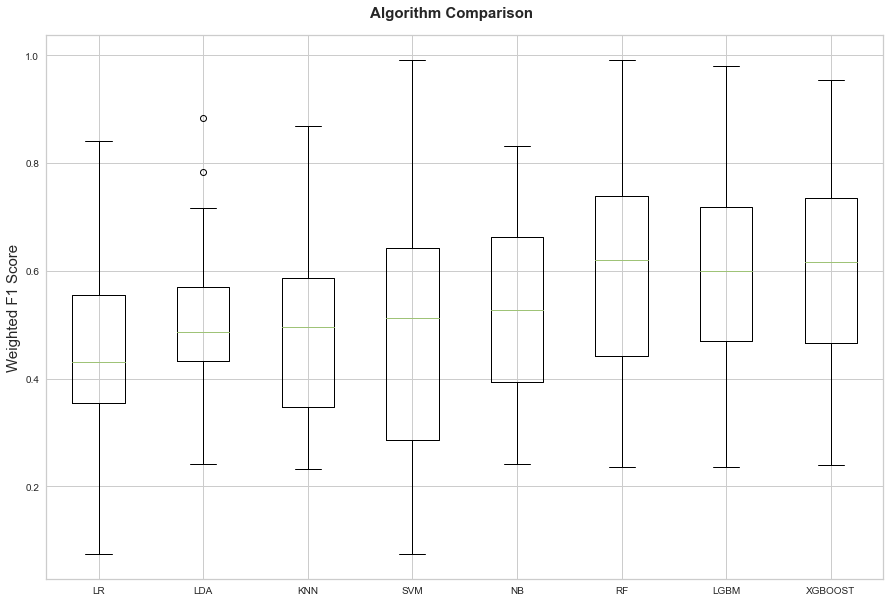

In [12]:
#Formatting plot
plt.rcParams.update({'font.size': 14})

#prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('LGBM', LGBMClassifier()))
models.append(('XGBOOST', XGBClassifier()))

# valuate each model in turn
print("MODEL: F1 Score (STD)")

results = []
names = []

for name, model in models:
    cv_results = model_selection.cross_val_score(model, X, Y, cv=gss, scoring='f1_weighted', groups=Z)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
#boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison', x=0.5, y=0.92, fontsize=15, fontweight='bold')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_ylabel('Weighted F1 Score', fontsize=15)
ax.set_xticklabels(names)
plt.show()

As predicted, the performance metric F1-score varies quite a lot due to our different train/test splits. However, we can see that the ensemble models such as Random Forest, LightGBM and XGBoost perform the best on our dataset. In the next cell we'll do the exact same thing except for this time we'll create a pipeline that also includes a scalar. This means that for each train/test split the data will be scaled to our training data (each feature scaled from 0-1) and then the test data will be transformed to fit this scale. This avoids information leaking in from the test data.

MODEL: F1 SCORE (STD)
LR: 0.498662 (0.151537)
LDA: 0.496584 (0.138348)
KNN: 0.637622 (0.124533)
SVM: 0.597886 (0.182827)
NB: 0.521742 (0.167614)
RF: 0.604850 (0.192134)
LGBM: 0.600538 (0.182341)
XGBOOST: 0.596742 (0.179303)


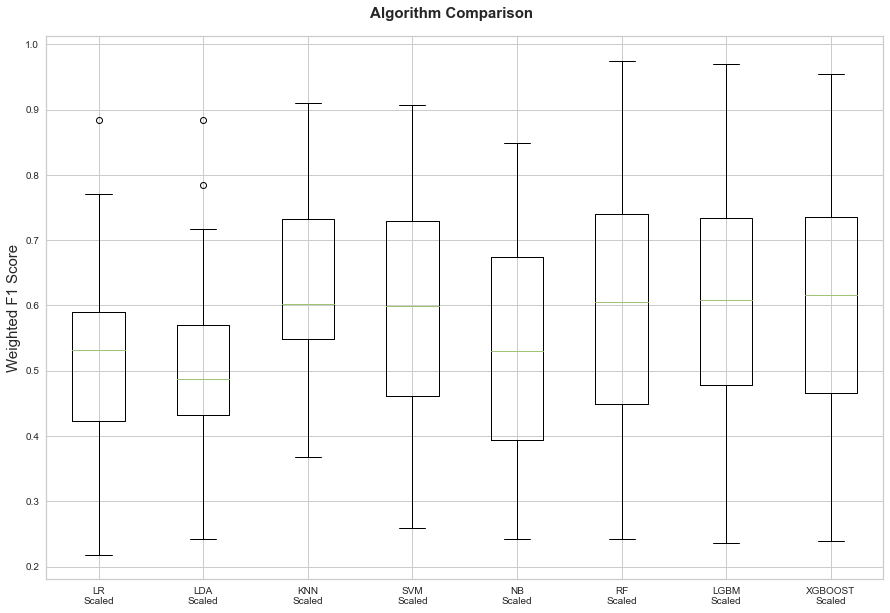

In [13]:
print("MODEL: F1 SCORE (STD)")

results = []
names = []

scalar = MinMaxScaler()

for name, model in models:
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)]) 
    cv_results = model_selection.cross_val_score(pipeline, X, Y, cv=gss, scoring='f1_weighted', groups=Z)
    results.append(cv_results)
    names.append(name+'\nScaled')
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison', x=0.5, y=0.92, fontsize=15, fontweight='bold')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_ylabel('Weighted F1 Score', fontsize=15)
ax.set_xticklabels(names)
plt.show()

We can see that there is still quite a large variance in our model performance scores, but the distance based models (KNN and SVM) have had a significant performance increase. This can be expected as the models are now not as dependent on the features with larger numerical variability.

Next we'll create a smaller GroupShuffleSplit subset and assess the confusion matrices of these scaled models on the same data. The confusion matrix will give us a better representation of how well the models are performing. To make things a little more robust we'll only select splits that contain at least 150 samples in the test group (20%) and at least 500 samples in the train group (65%). This will _hopefully_ remove any splits that may contain test sets that have too little or too many data points.

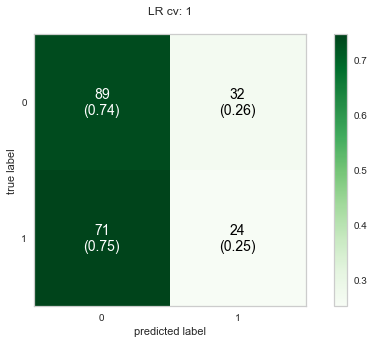

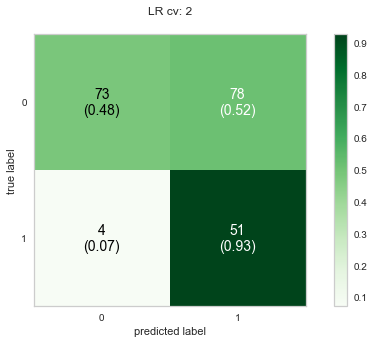

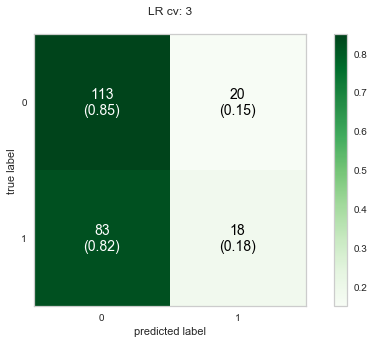

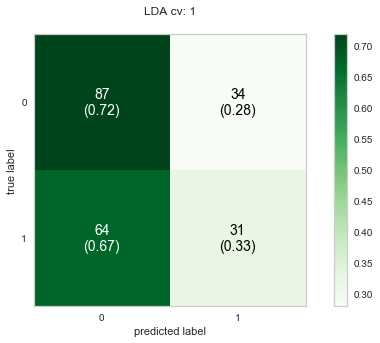

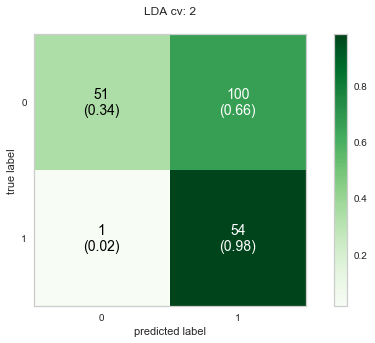

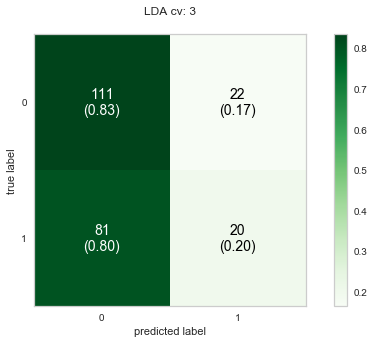

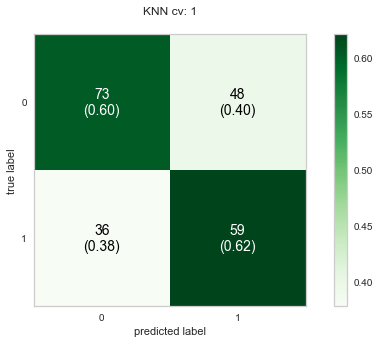

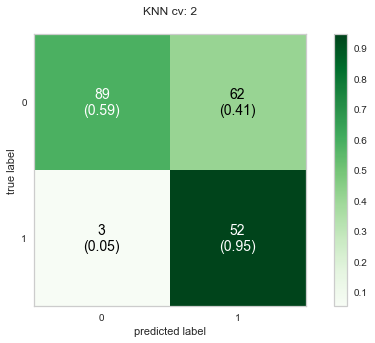

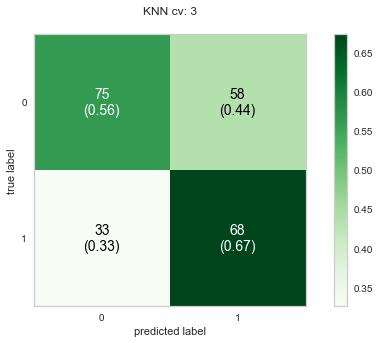

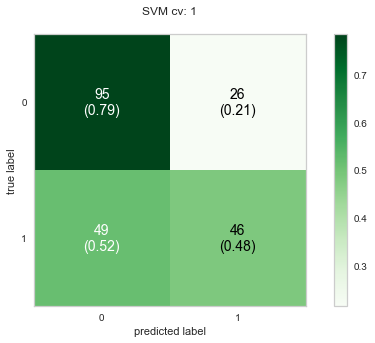

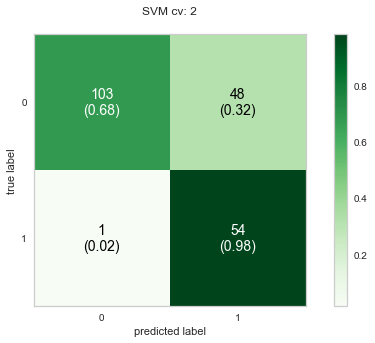

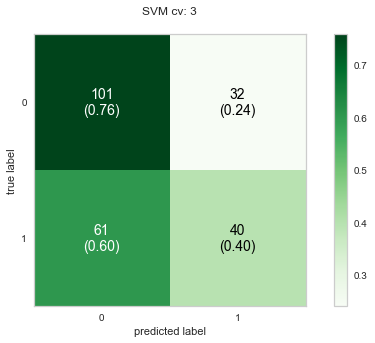

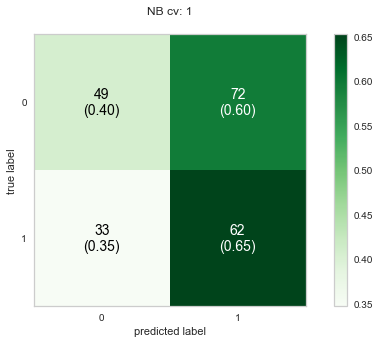

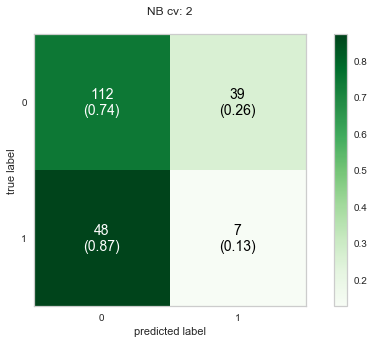

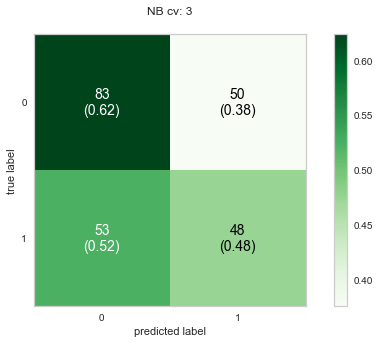

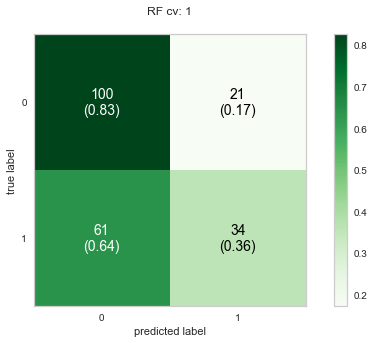

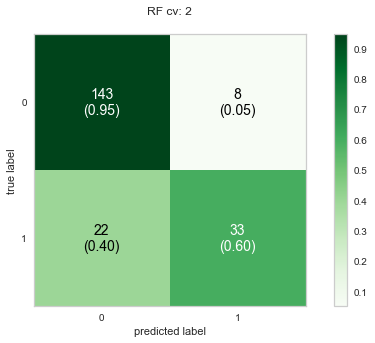

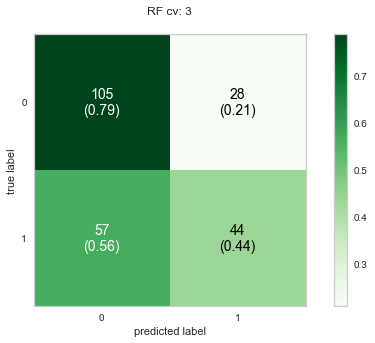

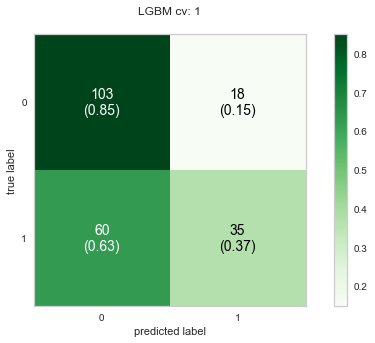

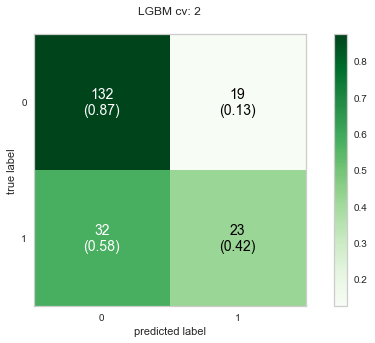

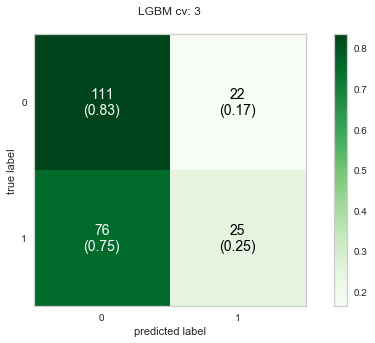

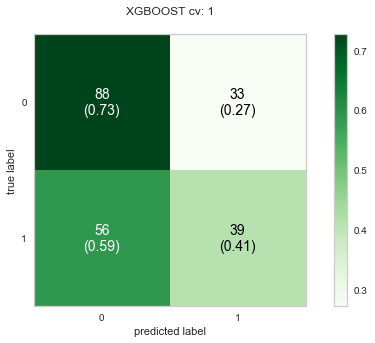

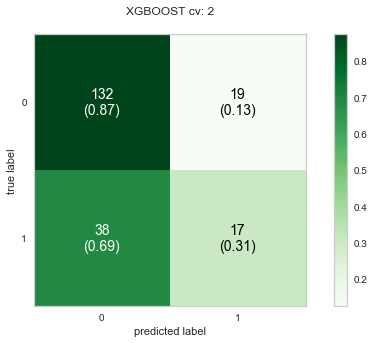

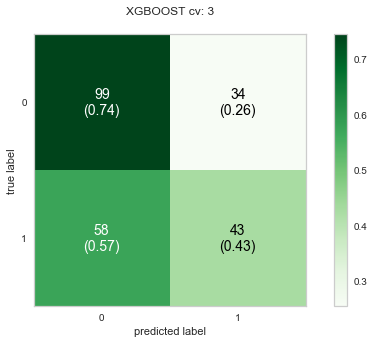

In [11]:
#Creating a new smaller split size
gsscf = GroupShuffleSplit(n_splits=3, train_size=0.8, random_state=48)

#Looping through models to print confusion matrices
for name, model in models:
    for i, (train, test) in enumerate(gsscf.split(X, Y, Z)):
        if len(test) >= 150 and len(train) >= 500:
            
            pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
            pipeline.fit(X.iloc[train].values, Y.iloc[train].values)
            Y_pred = pipeline.predict(X.iloc[test].values)
        
            conf_mat = confusion_matrix(Y.iloc[test].values, Y_pred)
    
            fig, ax = plot_confusion_matrix(conf_mat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap='Greens',
                                figsize=(10,5))
            ax.set_title(name + ' cv: '+str(i+1))
            plt.show()

From the confusion matrices we can see how all of the models performed over the 3 new CV splits. Overall, the amount of false positives (barren areas that have been classified as mineralised) is encouragingly low, meaning the models tend to say areas are barren more often than mineralised. This is much better than the alternative. However, the Logistic Regression and Linear Discriminant Analysis models are performing quite poorly which is important to note.

Next we'll look at the receiver operator characteristics for each model and go back to using all the splits, however we'll keep some test/train sample number restraints, still only including splits with more than 150 test samples and more than 500 training samples.

### Receiver Operator Characteristics

In [12]:
#Defining a function that will analyse the ROC curves for each split
def plot_roc(X, Y, gss, model, name):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(15,10))
    
    for i, (train, test) in enumerate(gss.split(X, Y, Z)):
        if len(test) >= 150 and len(train) >= 500:
    
            model.fit(X.iloc[train], Y.iloc[train])
            viz = plot_roc_curve(model, X.iloc[test], Y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic - "+name)
    ax.get_legend().remove()
    plt.show()

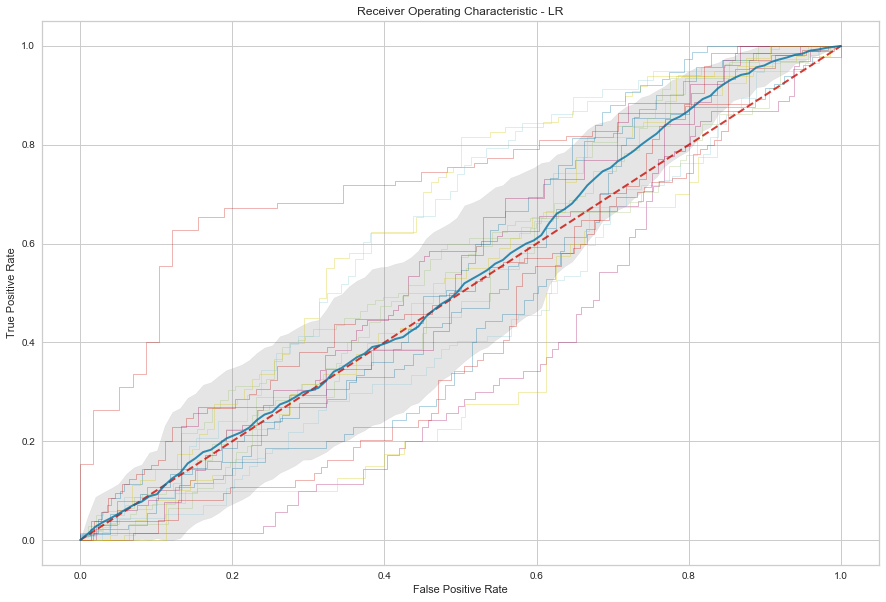

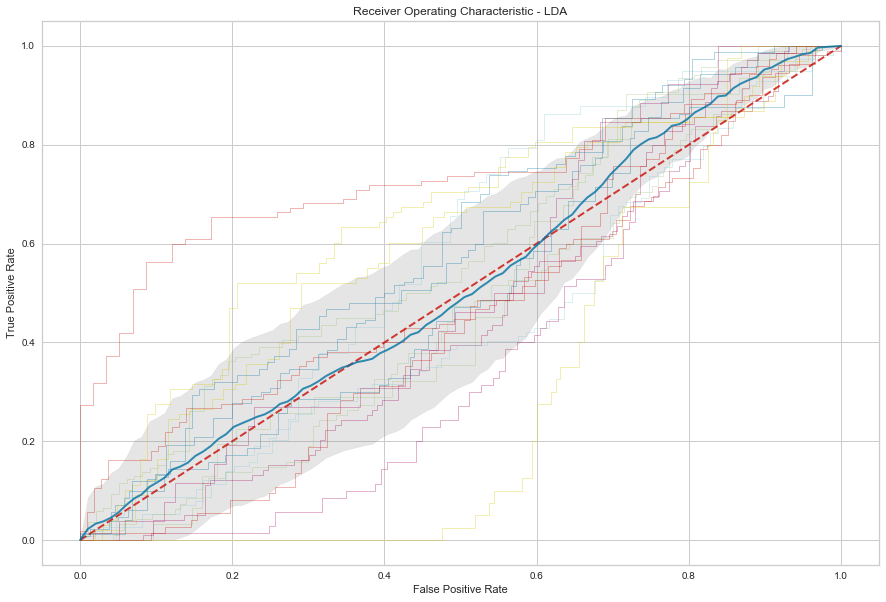

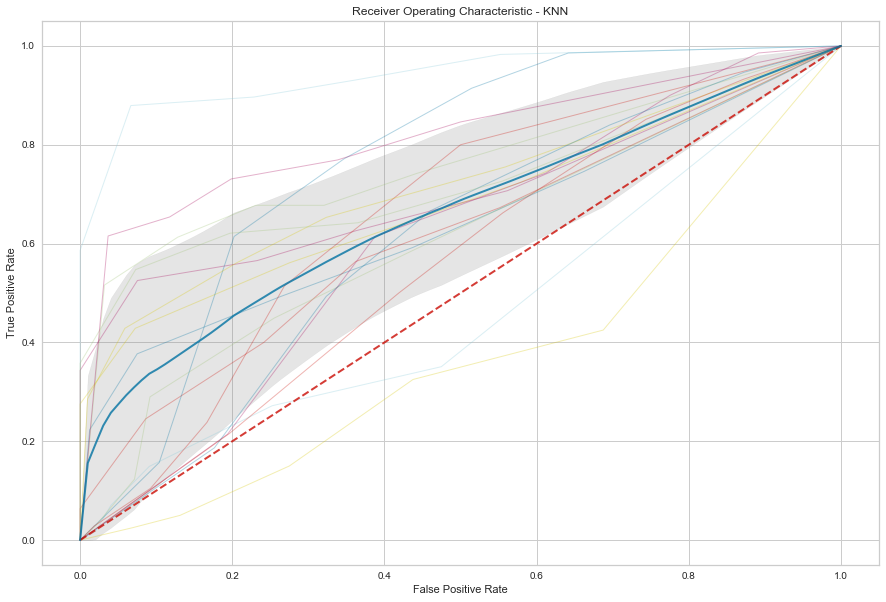

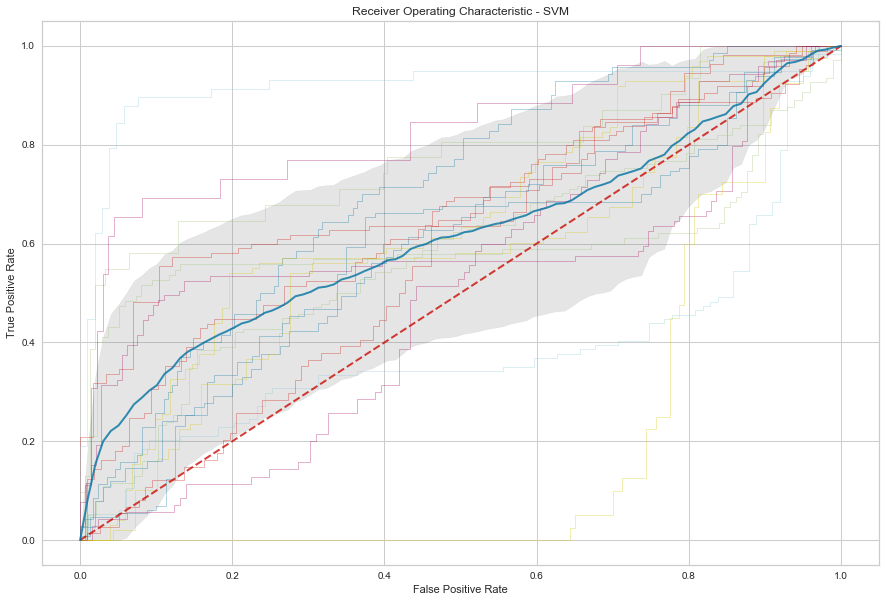

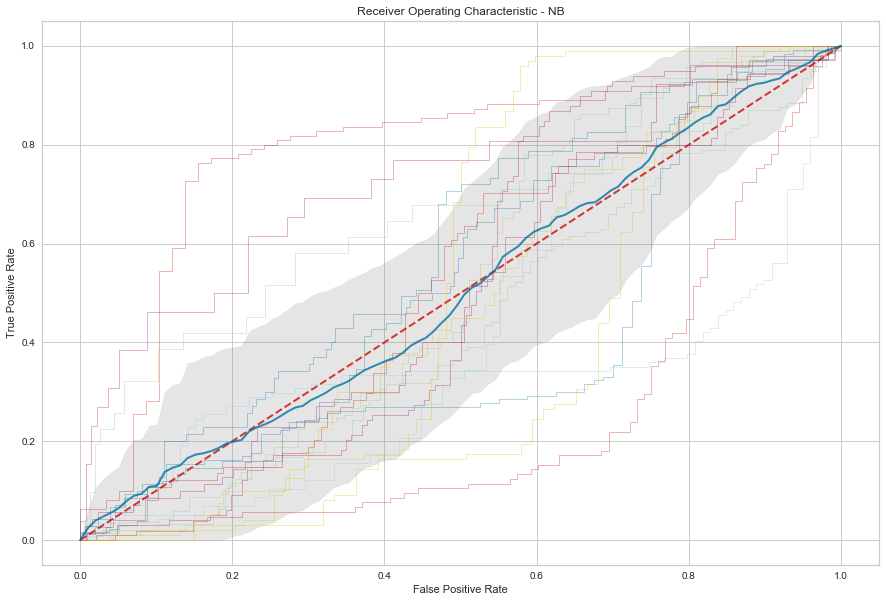

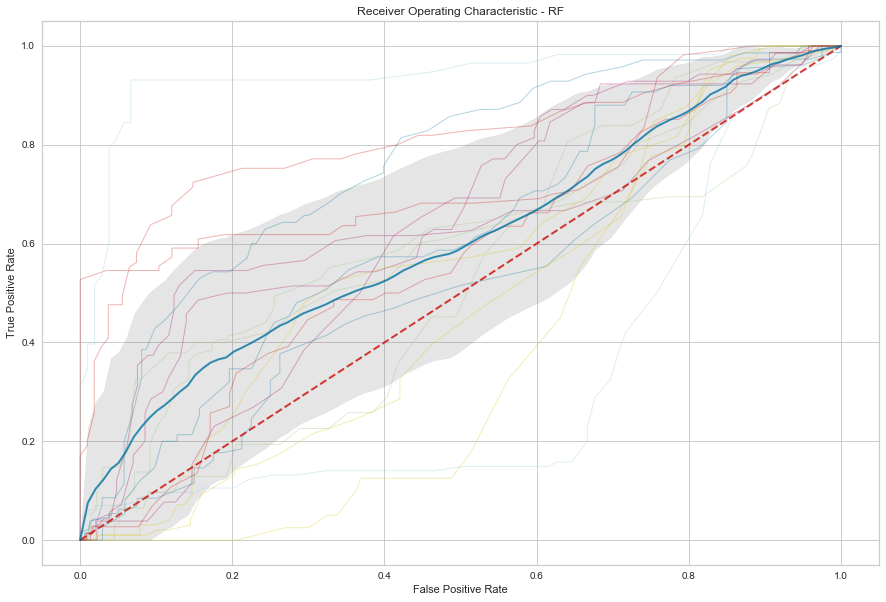

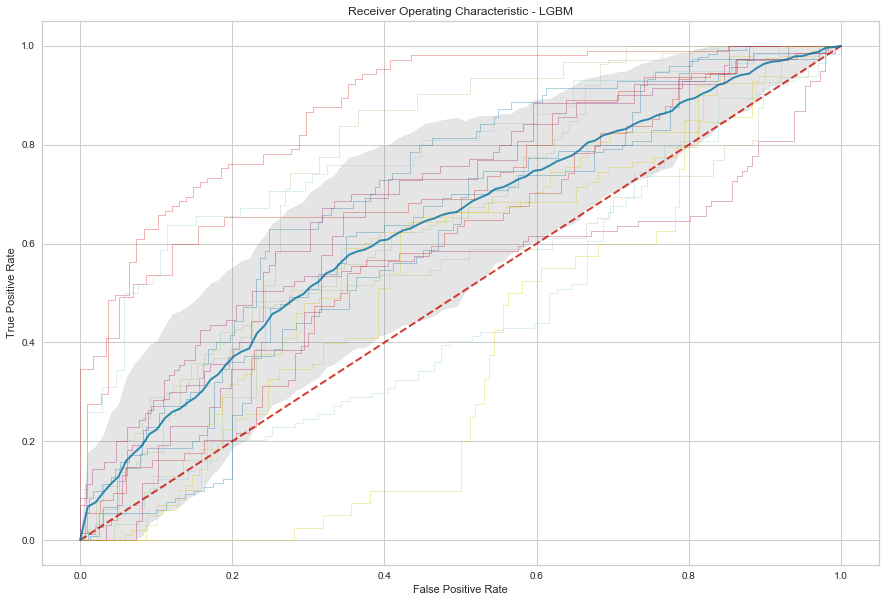

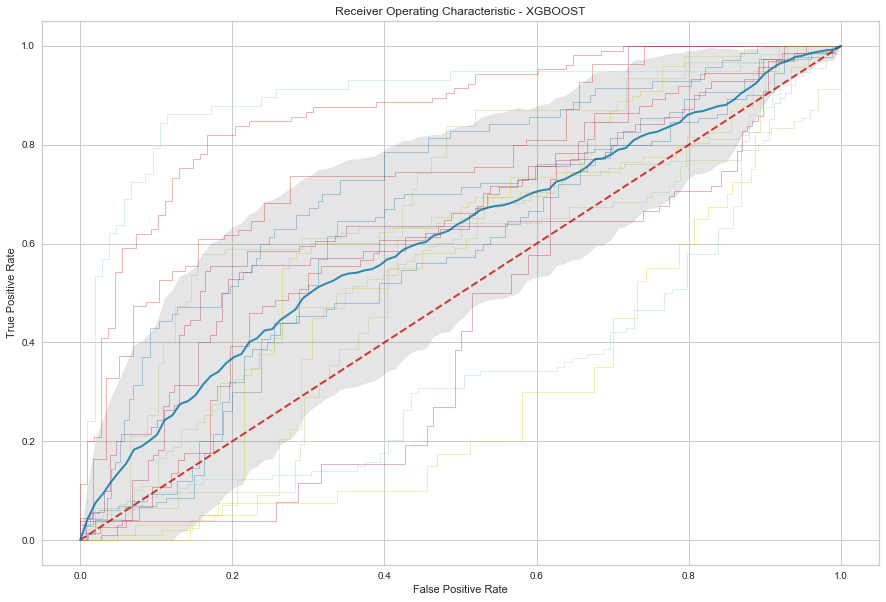

In [13]:
#Plotting each model
for name, model in models:
    pipeline = Pipeline([('transformer', scalar), ('clf', model)])
    plot_roc(X, Y, gss, model=pipeline, name=name)

Again, we can see that the Logistic Regression and Linear Discriminant Analysis models are performing poorly, as well as the Naive Bayes classifier. All models share cross validation splits that perform really well and splits that perform really poorly, emphasising the importance of including so many splits. Even though the models seem to be performing 'okayish', it's still good to be skeptical of overfitting/underfitting. Next we'll look at what individual model hyperparameters could increase our classification score, while preventing overfitting.

## Individual Model Assessment

In the next few cells we'll undergo a few different things for each model;

1. Perform a hyper parameter grid search and assess various performance metrics 
2. Plot the learning curve (trained results vs test results) to assess overfitting/underfitting
3. Play around with the hyperparameters until a happy medium is reached

In an ideal world we will see the same parameters selected for each of the different metrics, but we'll use a combination of the best parameters and the plotted learning curve to select the best versions of our models.

### MODEL 1 - Logistic Regression

In [69]:
#Select Logistic Regression as our model
model = LogisticRegression()

In [70]:
#Set the parameters to search through
params = dict(C=np.logspace(0, 4, 10),
              penalty=['l1', 'l2'])

#Select the metrics to check
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Loop through the metrics to see which parameters perform the best
for metric in metrics:
    searchCV = GridSearchCV(model, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score ('+metric+'): '+str(searchCV.best_score_))
    print('__________________________________________')

{'C': 1.0, 'penalty': 'l2'}
Best Score (accuracy): 0.48568501177125917
__________________________________________
{'C': 59.94842503189409, 'penalty': 'l2'}
Best Score (precision): 0.27756132707103004
__________________________________________
{'C': 1.0, 'penalty': 'l2'}
Best Score (recall): 0.15089486168076566
__________________________________________
{'C': 1.0, 'penalty': 'l2'}
Best Score (f1): 0.14851949651977445
__________________________________________


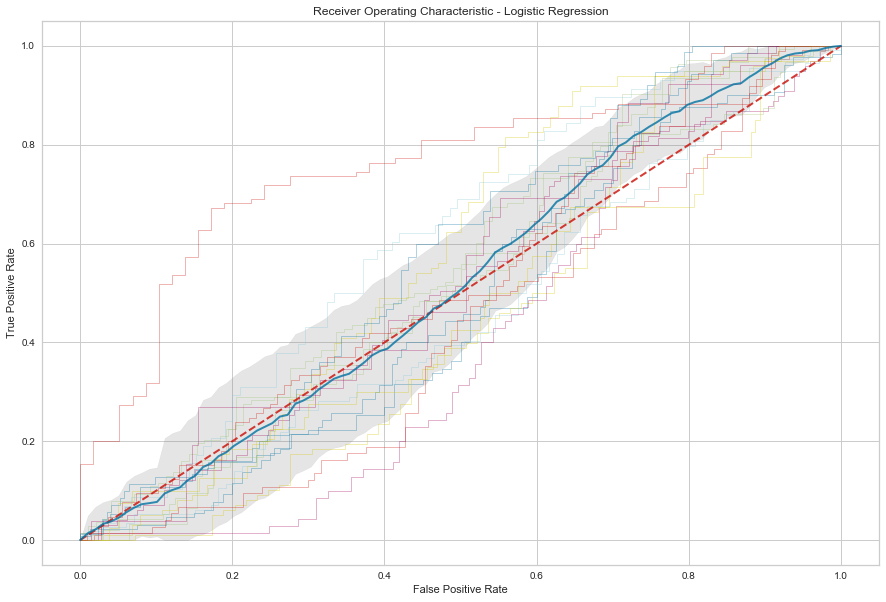

In [231]:
#Selecting our model parameters (these have been customised)
model = LogisticRegression(C=0.5, penalty='l2', solver='liblinear')
pipeline = Pipeline([('transformer', scalar), ('clf', model)])

#Plot ROC curve
plot_roc(X, Y, gss, model=pipeline, name='Logistic Regression')

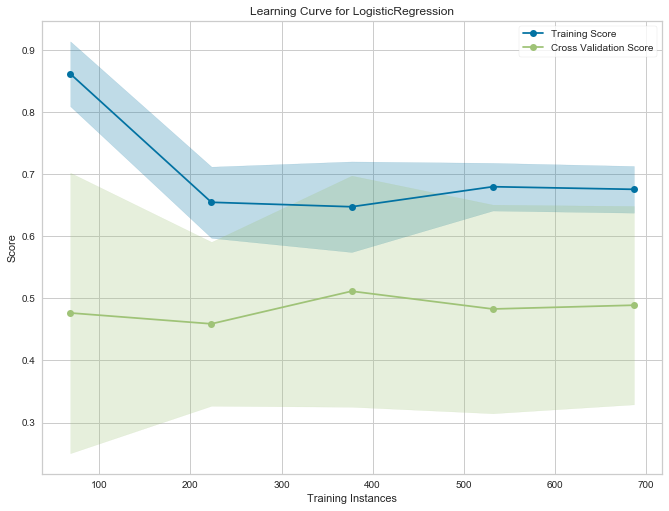

In [232]:
#Plotting the learning curve
visualizer = LearningCurve(pipeline, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 2 - Linear Discrimination Analysis

In [23]:
#Select Linear Discrimination Analysis
model = LinearDiscriminantAnalysis()

In [24]:
#Set the parameters to search through
params = dict(solver = ['svd', 'lsqr', 'eigen'],
             shrinkage = [None, 'auto'],
             n_components = [1, 2, 3, 4, 5, 7, 10, 15])

#Select the metrics to check
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Loop through the metrics to see which parameters perform the best
for metric in metrics:
    searchCV = GridSearchCV(model, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score '+metric+': '+str(searchCV.best_score_))
    print('__________________________________________')

{'n_components': 1, 'shrinkage': 'auto', 'solver': 'lsqr'}
Best Score accuracy: 0.5232430106688672
__________________________________________
{'n_components': 1, 'shrinkage': 'auto', 'solver': 'lsqr'}
Best Score precision: 0.35715073298595384
__________________________________________
{'n_components': 1, 'shrinkage': None, 'solver': 'lsqr'}
Best Score recall: 0.24016904383951346
__________________________________________
{'n_components': 1, 'shrinkage': None, 'solver': 'lsqr'}
Best Score f1: 0.2398612432295345
__________________________________________


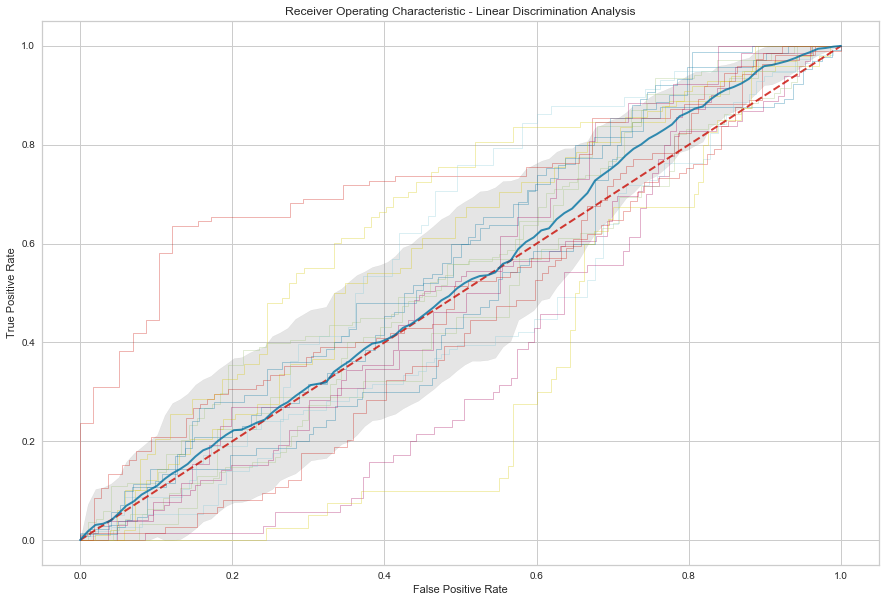

In [83]:
#Selecting our model parameters (these have been customised)
model = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

#Plot ROC curve
plot_roc(X, Y, gss, model, name='Linear Discrimination Analysis')

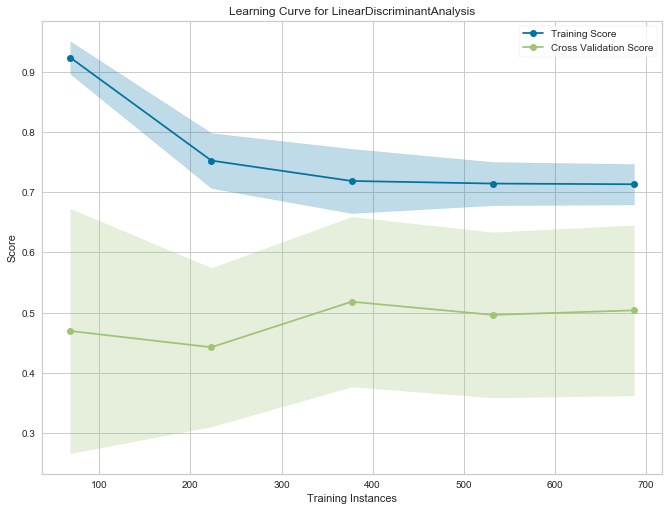

In [84]:
#Plotting the learning Curve
visualizer = LearningCurve(model, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 3 - K Nearest Neighbours

For K-Nearest Neighbour we'll also plot the loop through the amount of neighbours to help visualise this parameter selection

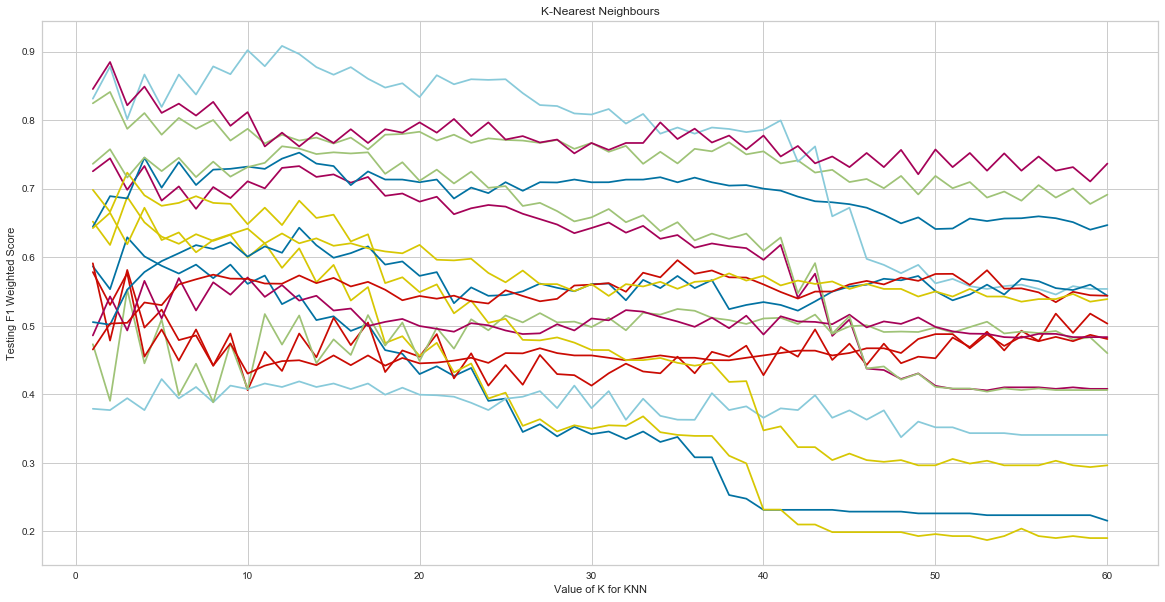

In [85]:
#Formatting plot
plt.figure(figsize=(20,10))

#Looping through 60 different neighbours
for i, (train, test) in enumerate(gss.split(X, Y, Z)):
    if len(test) >= 150 and len(train) >= 500:
    
        k_range = range(1, 61)
        scores = []

        for k in k_range:
            pipeline = Pipeline([('transformer', scalar), ('clf', KNeighborsClassifier(n_neighbors=k))])
            pipeline.fit(X.iloc[train], Y.iloc[train])
            y_pred = pipeline.predict(X.iloc[test])
            scores.append(f1_score(Y.iloc[test], y_pred, average='weighted'))

        plt.plot(k_range, scores, label='CV: '+str(i))
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing F1 Weighted Score')
        plt.title('K-Nearest Neighbours')

In [28]:
#Creating a pipeline of scaler and KNN
pipeline = Pipeline([('transformer', scalar), ('clf', KNeighborsClassifier())])

In [86]:
#Selecting the parameters
params = dict(clf__n_neighbors=[8, 10, 12, 14, 18, 22, 26, 30, 40, 45, 50],
              clf__weights=['uniform', 'distance'],
             clf__metric=['euclidean', 'manhattan'])

#Creating a metrics list
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Looping through each metric
for metric in metrics:
    searchCV = GridSearchCV(pipeline, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score '+metric+': '+str(searchCV.best_score_))
    print('__________________________________________')

{'clf__metric': 'manhattan', 'clf__n_neighbors': 14, 'clf__weights': 'distance'}
Best Score accuracy: 0.6383693803813251
__________________________________________
{'clf__metric': 'manhattan', 'clf__n_neighbors': 14, 'clf__weights': 'uniform'}
Best Score precision: 0.5211762213782503
__________________________________________
{'clf__metric': 'manhattan', 'clf__n_neighbors': 14, 'clf__weights': 'distance'}
Best Score recall: 0.4592390316631915
__________________________________________
{'clf__metric': 'manhattan', 'clf__n_neighbors': 14, 'clf__weights': 'distance'}
Best Score f1: 0.4559138050497112
__________________________________________


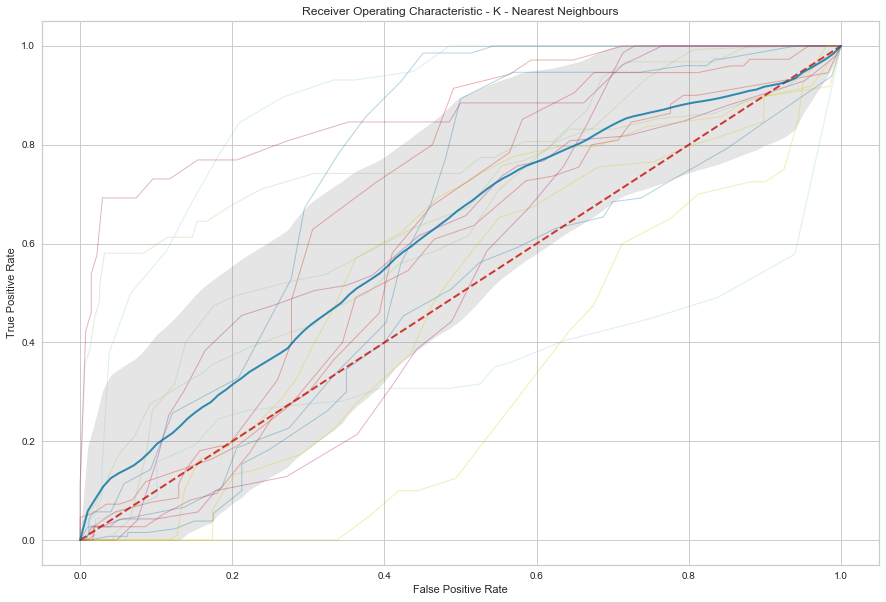

In [236]:
#Adjusting model parameters
model = KNeighborsClassifier(metric='euclidean', n_neighbors=35, weights='uniform', algorithm='auto')
pipeline = Pipeline([('transformer', scalar), ('clf', model)])

#Plotting ROC curve
plot_roc(X, Y, gss, model=pipeline, name='K - Nearest Neighbours')

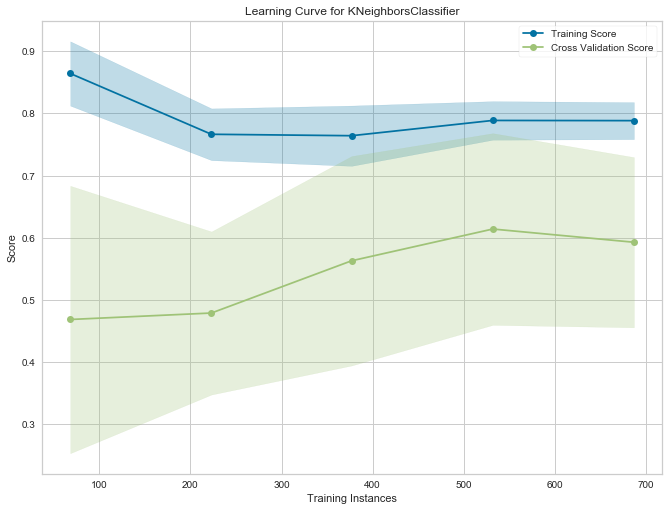

In [237]:
#Plotting learning curve
visualizer = LearningCurve(pipeline, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 4 - Support Vector Machine

In [39]:
#Creating a pipeline of scaler and SVM
pipeline = Pipeline([('transformer', scalar), ('clf', SVC())])

In [40]:
#Selecting parameters to search through
params = dict(clf__C=[0.01, 0.1, 1, 10],
              clf__gamma=[1, 0.1, 0.01, 0.001, 0.0001],
             clf__kernel=['rbf', 'sigmoid', 'poly', 'linear'])

#Creating a list of metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Looping through metrics
for metric in metrics:
    searchCV = GridSearchCV(pipeline, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score '+metric+': '+str(searchCV.best_score_))
    print('__________________________________________')

{'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Best Score accuracy: 0.6647050397510479
__________________________________________
{'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Best Score precision: 0.532738546931855
__________________________________________
{'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'sigmoid'}
Best Score recall: 0.5145308317794587
__________________________________________
{'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'sigmoid'}
Best Score f1: 0.461464299193828
__________________________________________


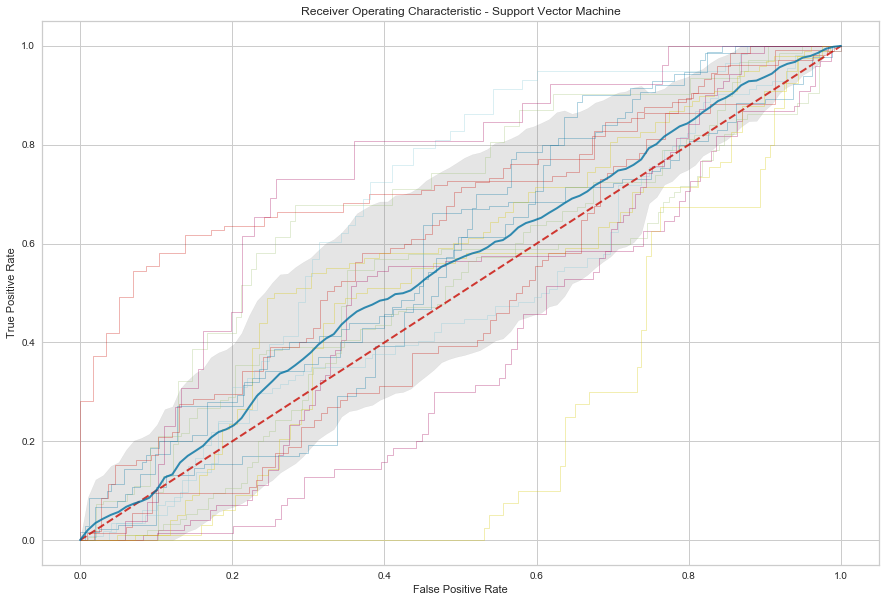

In [229]:
#Setting model parameters
model = SVC(C=0.5, gamma=0.5, kernel='poly')
pipeline = Pipeline([('transformer', scalar), ('clf', model)])

#Plotting ROC curve
plot_roc(X, Y, gss, model=pipeline, name='Support Vector Machine')

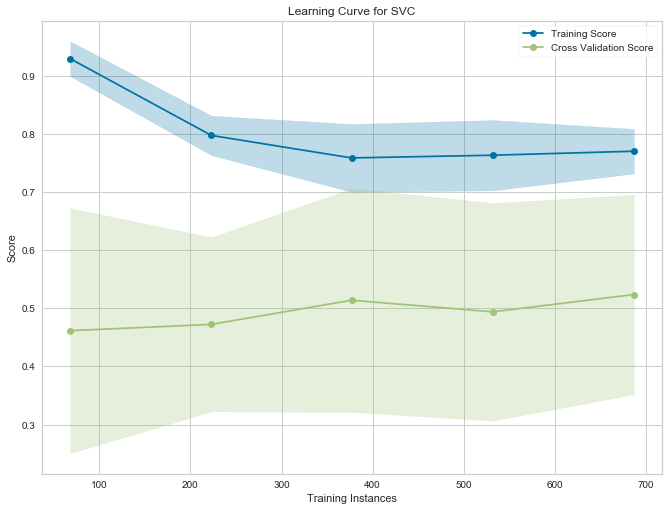

In [230]:
#Plotting learning cure
visualizer = LearningCurve(pipeline, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 5 - Naive Bayes

As Naive Bayes doesn't have any significant parameters to tune we can just run with what we've got.

In [58]:
#Selecting Naive Bayes classifier
model = GaussianNB()

In [59]:
#Setting metrics list
metrics = ['accuracy', 'precision', 'recall', 'f1']

#looping through the metrics
for metric in metrics:
    scores = cross_val_score(model, X, Y, Z, cv=gss, scoring=metric)

    print(metric+": %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print('__________________________________________')

accuracy: 0.54 (+/- 0.27)
__________________________________________
precision: 0.41 (+/- 0.53)
__________________________________________
recall: 0.29 (+/- 0.53)
__________________________________________
f1: 0.28 (+/- 0.44)
__________________________________________


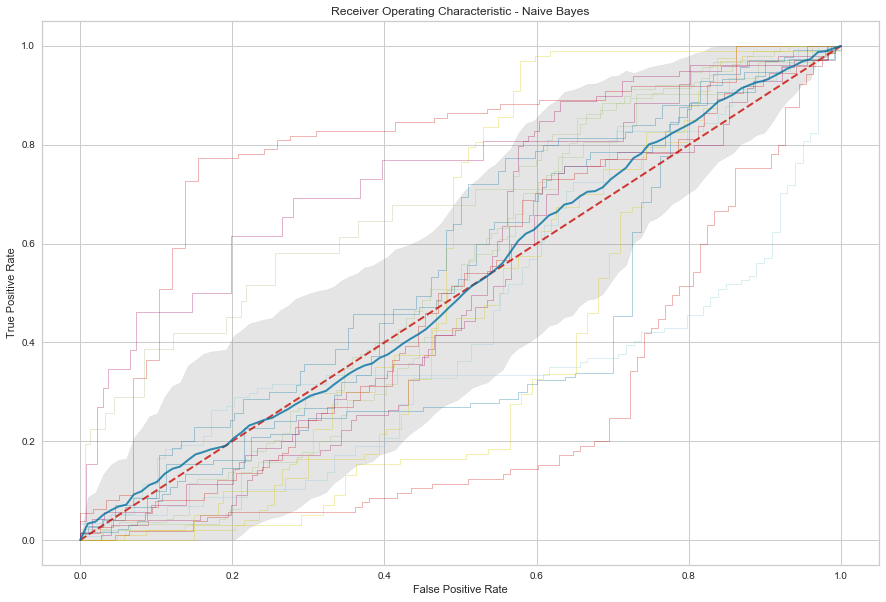

In [60]:
#Selecting model
model = GaussianNB()

#Plotting ROC curve
plot_roc(X, Y, gss, model=model, name='Naive Bayes')

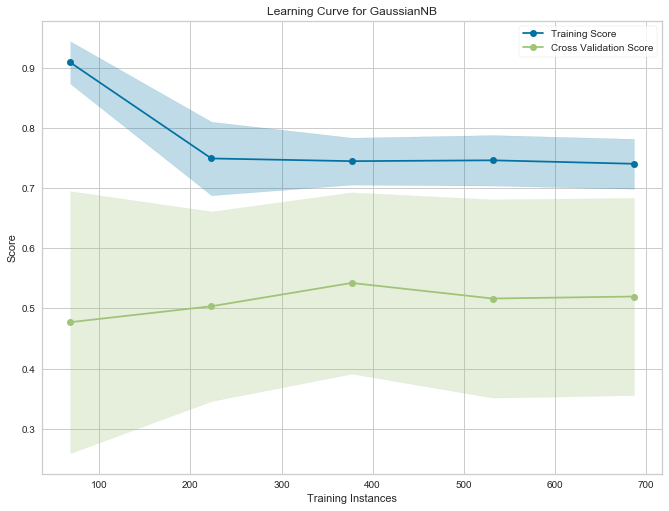

In [61]:
#Plotting Learning curve
visualizer = LearningCurve(model, cv=gss, scoring='f1_weighted', n_jobs=4, groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 6 - Random Forest

In [57]:
#Selecting random forest model
model = RandomForestClassifier()

In [121]:
#Selecting paramters to search through
params = dict(n_estimators = [20, 30, 50, 100],
                  max_depth = [20, 30, 50, 100], 
                  min_samples_leaf = [20, 30, 50, 100],
                  criterion = ['gini', 'entropy'])

#Selecting metric list
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Looping through metrics
for metric in metrics:
    searchCV = GridSearchCV(model, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score '+metric+': '+str(searchCV.best_score_))
    print('__________________________________________')

{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 20, 'n_estimators': 30}
Best Score accuracy: 0.6539281849252804
__________________________________________
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20, 'n_estimators': 20}
Best Score precision: 0.46315572009853495
__________________________________________
{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 20, 'n_estimators': 20}
Best Score recall: 0.21977207934924917
__________________________________________
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 20, 'n_estimators': 30}
Best Score f1: 0.26936649485801245
__________________________________________


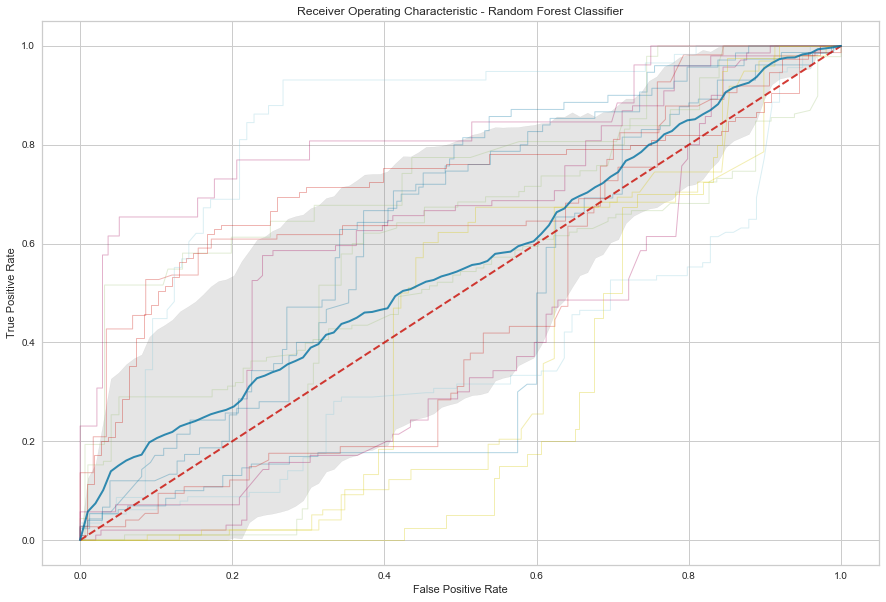

In [241]:
#Selecting model with updated parameters
model = RandomForestClassifier(criterion='gini', max_depth=100, max_features='auto', 
                               n_estimators=30, min_samples_leaf=50)

#Plotting ROC curve
plot_roc(X, Y, gss, model=model, name='Random Forest Classifier')

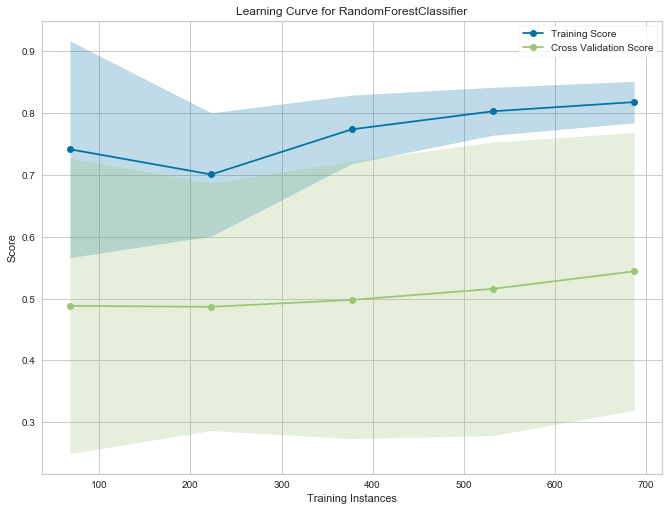

In [243]:
#Plotting learning curve
visualizer = LearningCurve(model, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 7 - Light GBM

In [108]:
#Selecting LGBM Classifier
model = LGBMClassifier()

In [109]:
#Selecting parameters to search through
params = dict(max_depth = [20, 30, 50, 100],
              learning_rate = [0.01,0.05,0.1],
              num_leaves = [100,200],
              n_estimators = [20, 50, 100])

#Selecting parameters list
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Looping through metrics
for metric in metrics:
    searchCV = GridSearchCV(model, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score '+metric+': '+str(searchCV.best_score_))
    print('__________________________________________')

{'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 100}
Best Score accuracy: 0.64355000865906
__________________________________________
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 20, 'num_leaves': 100}
Best Score precision: 0.4811741395983915
__________________________________________
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 20, 'num_leaves': 100}
Best Score recall: 0.2479383126525606
__________________________________________
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 20, 'num_leaves': 100}
Best Score f1: 0.29571227850437753
__________________________________________


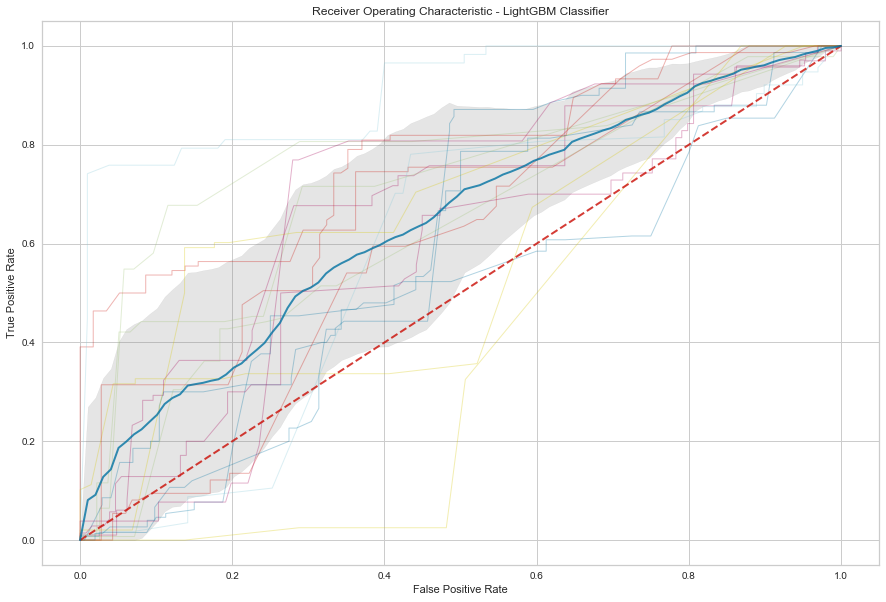

In [170]:
#Updating model with parameters
model = LGBMClassifier(learning_rate=0.008, max_depth=100, n_estimators=25, num_leaves=100)

#Plotting ROC curve
plot_roc(X, Y, gss, model=model, name='LightGBM Classifier')

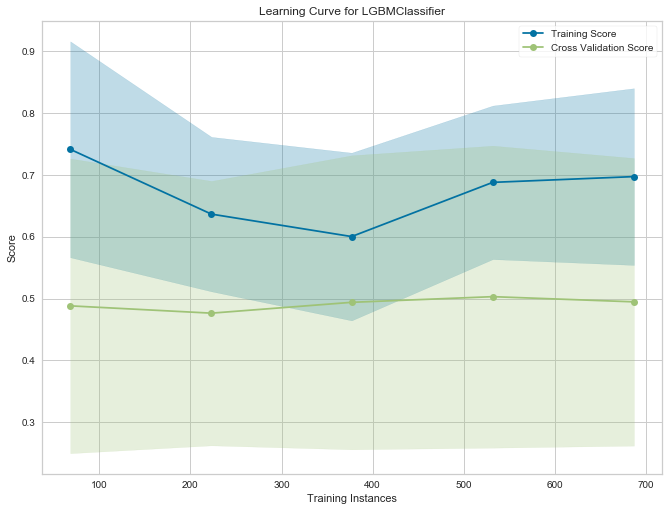

In [173]:
#Plotting learning curve
visualizer = LearningCurve(model, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### MODEL 8 - XGBoost

In [174]:
#Select XGBoost model
model = XGBClassifier()

In [176]:
#Select parameters to search through
params = dict(max_depth = [20, 50, 100],
    subsample = [0.6, 1.0],
    colsample_bytree = [0.5 ,0.8],
    n_estimators = [20, 50, 100],
    reg_alpha = [0.02, 0.04])

#Select metrics list
metrics = ['accuracy', 'precision', 'recall', 'f1']

#Loop through metrics list
for metric in metrics:
    searchCV = GridSearchCV(model, params, scoring=metric, n_jobs=1, cv=gss)

    searchCV.fit(X, Y, Z)  
    print(searchCV.best_params_)
    print('Best Score '+metric+': '+str(searchCV.best_score_))
    print('__________________________________________')

{'colsample_bytree': 0.8, 'max_depth': 20, 'n_estimators': 20, 'reg_alpha': 0.04, 'subsample': 1.0}
Best Score accuracy: 0.6683102397896795
__________________________________________
{'colsample_bytree': 0.8, 'max_depth': 20, 'n_estimators': 20, 'reg_alpha': 0.04, 'subsample': 1.0}
Best Score precision: 0.5510668503763471
__________________________________________
{'colsample_bytree': 0.8, 'max_depth': 20, 'n_estimators': 20, 'reg_alpha': 0.04, 'subsample': 1.0}
Best Score recall: 0.2573480427921144
__________________________________________
{'colsample_bytree': 0.8, 'max_depth': 20, 'n_estimators': 20, 'reg_alpha': 0.04, 'subsample': 1.0}
Best Score f1: 0.31584436837169866
__________________________________________


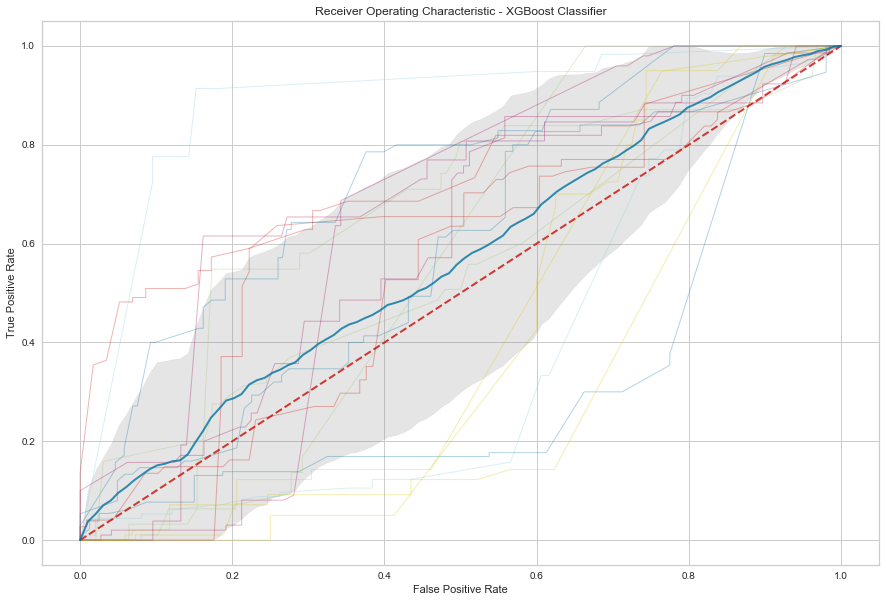

In [184]:
#Updating model parameters
model = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.05,  
                      colsample_bytree = 0.8,
                      subsample = 0.5,
                      objective='binary:logistic', 
                      n_estimators=20, 
                      reg_alpha = 0.5,
                      max_depth=100, 
                      gamma=20)

#Plotting ROC curve
plot_roc(X, Y, gss, model=model, name='XGBoost Classifier')

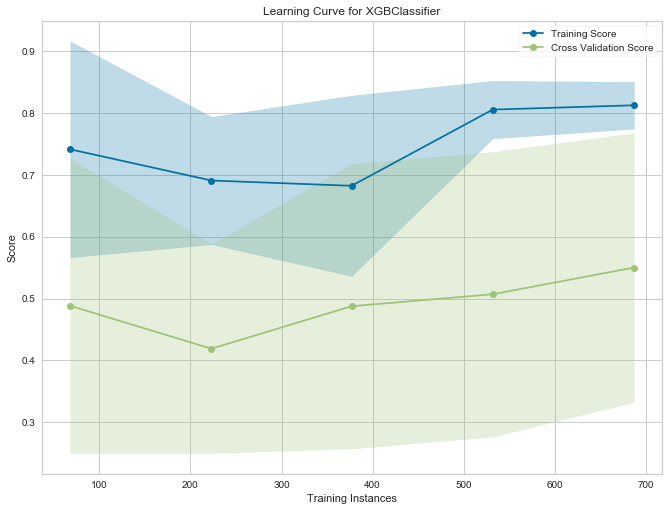

In [185]:
#Plotting learning curve
visualizer = LearningCurve(model, cv=gss, scoring='f1_weighted', groups=Z, size=(800, 600))
    
visualizer.fit(X, Y)

visualizer.show() 

### Bonus CNN Deep Learning

As an added extra, we'll throw in a convolutional neural network. I have refrained from including neural networks as a main component of this workflow purely on the basis that I don't fully understand how they work yet, but nonetheless we can create a network and see how it performs. We'll firstly select a smaller split size so my computer doesn't cook itself, and then create and run the model to see how it performs.

In [9]:
#Selecting a smaller number of cross validation splits
gss_nn = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=48)

We'll create a network with 10 input layers, a hidden layer with 20 neurons and another hidden layer with 10 neurons, while also adding dropout functions to the first two layers.

In [14]:
#Creating our neural network structure
def create_model():
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim= 10))
    model.add(Dropout(0.3))

    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(10, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#Putting the network into a scaler pipeline
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
pipeline = Pipeline([('transformer', scalar), ('clf', model)])

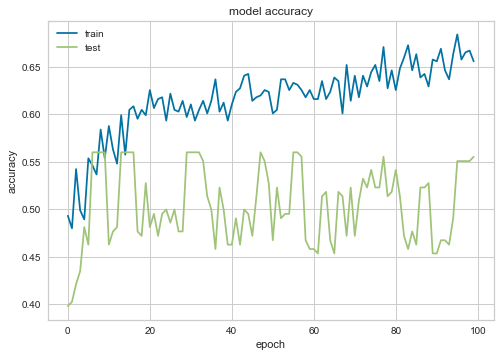

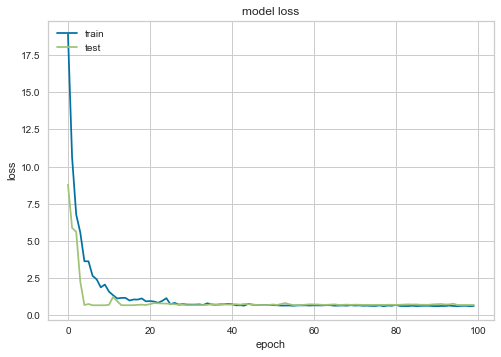

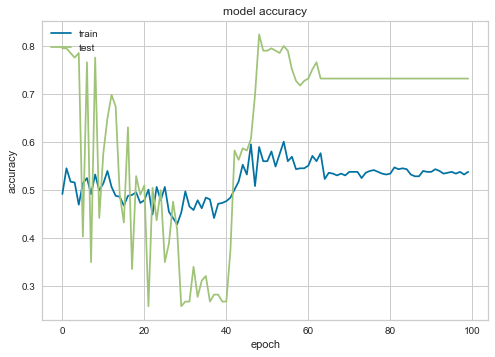

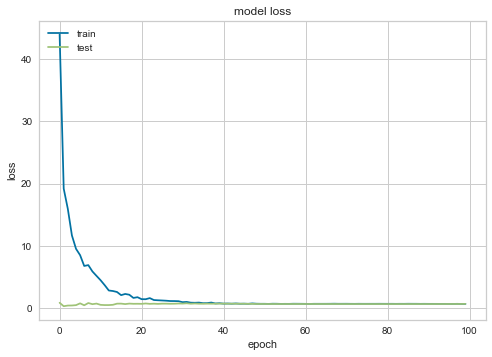

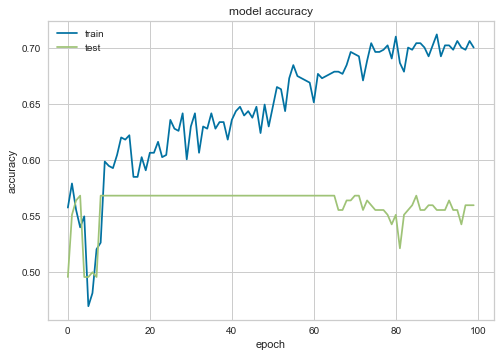

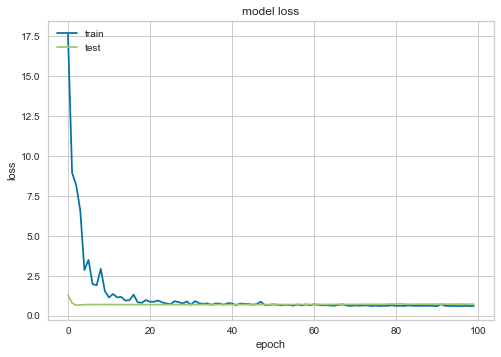

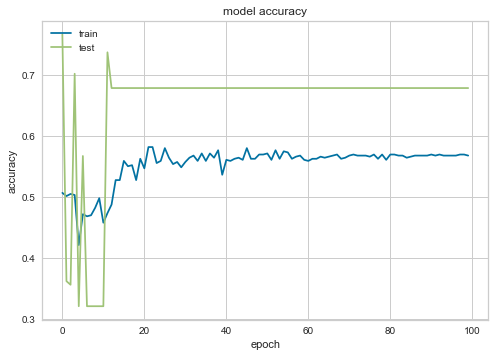

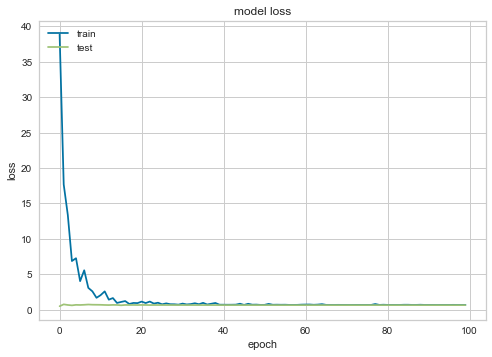

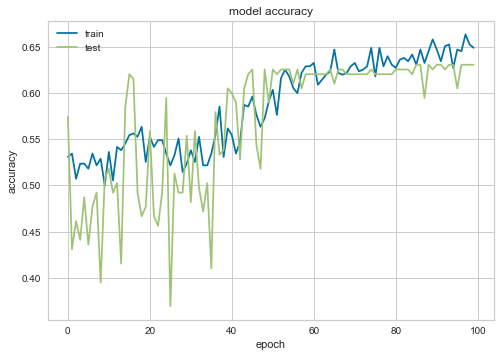

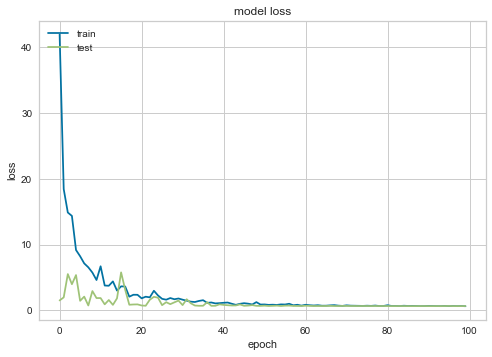

In [192]:
#Fitting the model and plotting the loss 
for i, (train, test) in enumerate(gss_nn.split(X, Y, Z)):
    if len(test) >= 150 and len(train) >= 500:
        
        # Fit the model
        history = model.fit(X.iloc[train], Y.iloc[train], validation_data=(X.iloc[test], Y.iloc[test]))
        
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

Here we can see that the model performs quite well on the last cross validation fold, with both the test and training data sharing a similar accuracy. The remaining folds tend to be a bit all over the place. This could be due to our vast differences in data between cross validation splits. After playing around for a couple hours to improve the neural network, let's see how the ROC curve looks for these 5 splits.

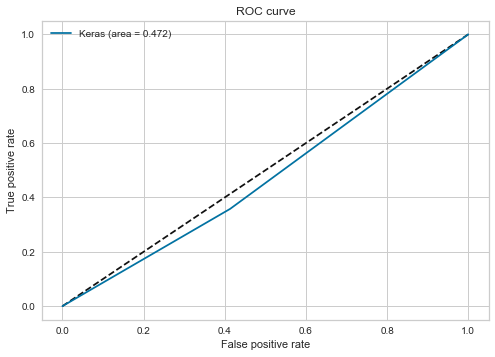

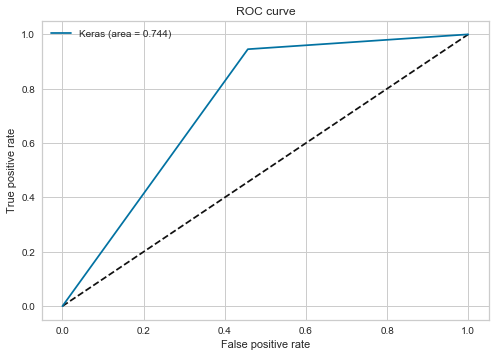

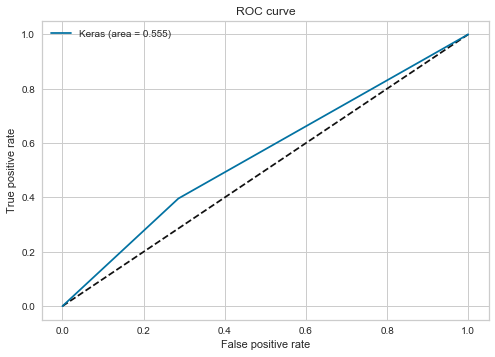

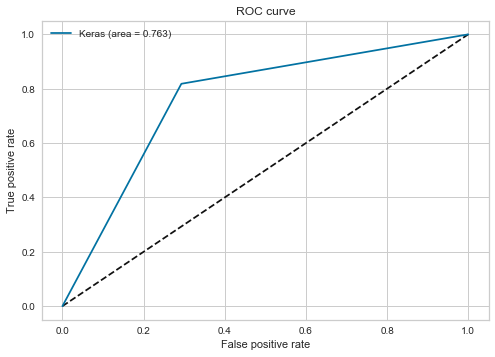

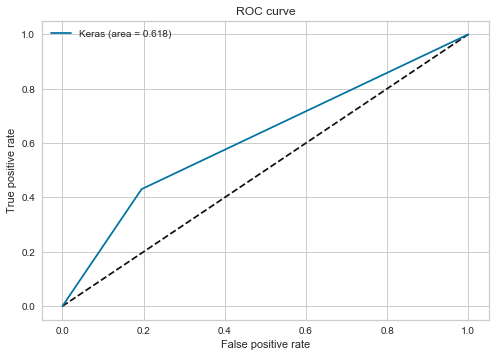

In [193]:
#Plotting the ROC curve for each cross validation set
for i, (train, test) in enumerate(gss_nn.split(X, Y, Z)):
    if len(test) >= 150 and len(train) >= 500:
    
        pipeline.fit(X.iloc[train], Y.iloc[train])
        y_pred_keras = pipeline.predict(X.iloc[test]).ravel()
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y.iloc[test], y_pred_keras)
        auc_keras = auc(fpr_keras, tpr_keras)
        
        auc_keras = auc(fpr_keras, tpr_keras)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

Similarly to our other models, the CNN ROC curve is quite sporadic. However, the majority all show an area under the curve >50% so that is promising. In the next section we will summarise all the model metrics and see which ones perform the best.

## Model Summary

Now we've viewed the best model parameters that also balance overfitting/underfitting, we can summarise all the model metrics in a table. To do this we'll first create a list of all the models, a scaler pipeline (for some) and their respective hyperparameters. 

In [15]:
#Creating a list of models
models = []
models.append(('LR', Pipeline([('transformer', scalar), 
                               ('estimator', LogisticRegression(C=0.5, 
                                                                penalty='l2', 
                                                                solver='liblinear'))])))
models.append(('LDA', LinearDiscriminantAnalysis(shrinkage='auto', 
                                                 solver='lsqr')))
models.append(('KNN', Pipeline([('transformer', scalar),
                                ('estimator', KNeighborsClassifier(metric='euclidean', 
                                                                   n_neighbors=35, 
                                                                   weights='uniform', 
                                                                   algorithm='auto'))])))
models.append(('SVM', Pipeline([('transformer', scalar),
                                ('estimator', SVC(C=0.6, 
                                                  gamma=0.6, 
                                                  kernel='poly', 
                                                  probability=True))])))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(criterion='gini', 
                                            max_depth=100, 
                                            max_features='auto', 
                                            n_estimators=30, 
                                            min_samples_leaf=50)))
models.append(('LGBM', LGBMClassifier(learning_rate=0.008, 
                                      max_depth=100, 
                                      n_estimators=25, 
                                      num_leaves=100)))
models.append(('XGBOOST', XGBClassifier(silent=False, 
                                        scale_pos_weight=1,
                                        learning_rate=0.05,  
                                        colsample_bytree = 0.8,
                                        subsample = 0.5,
                                        objective='binary:logistic', 
                                        n_estimators=20, 
                                        reg_alpha = 0.5,
                                        max_depth=100, 
                                        gamma=20)))
models.append(('CNN', Pipeline([('transformer', scalar),
                                ('estimator', KerasClassifier(build_fn=create_model,
                                                              epochs=100,
                                                              batch_size=5,
                                                              verbose=0))])))


In the next cell we'll fit the models again and this time we'll append the metric evaluations into several lists.

In [16]:
#Lists for average
model_all = []
accuracy_all = []
precision_all = []
recall_all = []
f1_all = []
roc_auc_all = []

#Looping through each model
for name, model in models:
    
    #Create metric lists for each split
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc = []
    
    #Looping through each cross validation split
    for i, (train, test) in enumerate(gss.split(X, Y, Z)):
        if len(test) >= 150 and len(train) >= 500:
            
            #Fit model and predict test data
            model.fit(X.iloc[train], Y.iloc[train])
            y_pred = model.predict(X.iloc[test])
            
            #Get temp evaluation metric
            accuracy_temp = accuracy_score(Y.iloc[test], y_pred)
            precision_temp = precision_score(Y.iloc[test], y_pred)
            recall_temp = recall_score(Y.iloc[test], y_pred)
            f1_temp = f1_score(Y.iloc[test], y_pred, average='weighted')
            roc_auc_temp = roc_auc_score(Y.iloc[test], y_pred)
            
            #Append metrics for each split
            accuracy.append(accuracy_temp)
            precision.append(precision_temp)
            recall.append(recall_temp)
            f1.append(f1_temp)
            roc_auc.append(roc_auc_temp)
         
    #Append the averages for each model
    model_all.append(name)
    accuracy_all.append(sum(accuracy) / len(accuracy))
    precision_all.append(sum(precision) / len(precision))
    recall_all.append(sum(recall) / len(recall))
    f1_all.append(sum(f1) / len(f1))
    roc_auc_all.append(sum(roc_auc) / len(roc_auc))

In [17]:
#Creating a summary table of each models metrics
df_summary = pd.DataFrame(
    {'Model': model_all,
     'Accuracy': accuracy_all,
     'Precision': precision_all,
     'Recall': recall_all,
     'F1 Score': f1_all,
     'AUC': roc_auc_all
    })

#Printing the summary table
df_summary.round(2).style.background_gradient(cmap='winter')

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.510000,0.290000,0.130000,0.430000,0.490000
1,LDA,0.480000,0.320000,0.220000,0.440000,0.490000
2,KNN,0.570000,0.500000,0.420000,0.560000,0.580000
3,SVM,0.540000,0.380000,0.280000,0.490000,0.540000
4,NB,0.510000,0.370000,0.270000,0.450000,0.510000
5,RF,0.540000,0.260000,0.160000,0.460000,0.520000
6,LGBM,0.580000,0.140000,0.070000,0.450000,0.520000
7,XGBOOST,0.550000,0.250000,0.150000,0.470000,0.510000
8,CNN,0.550000,0.440000,0.320000,0.510000,0.550000


From this we can see that the models that perform the best are the KNN, SVM and the CNN but the overall model metrics are quite poor and not much better than a stab in the dark (50-50 guess). However, once validated there is potential to combine model results and use geological background knowledge to determine mineral prospectivity. To validate these models, we'll deploy them on the entire craton and compare areas that have been classified as mineralised to known/existing deposits, ensuring that any of the drillhole data is excluded from validation. 

## Model Deployment

Our models are now ready to be deployed on our dataset of the entire craton. To do this we must first load in the data and get it in the same structure as our train/test data (remove unused columns).

In [247]:
#Reading in the entire craton dataset
df_dep = pd.read_csv('Gawler_Data.csv')

#Splitting data into features, areas of interests and zones
X_all = df_dep.drop(['Unnamed: 0', 'Areas_of_Interest', 'Zones', 'SA_RESIDUAL'], axis=1)

To make it easier to visualise our prediction maps, we'll load in a raster image with the same metadata (datum etc) that we want our prediction maps to have. That way we can just apply the metadata directly to model results and then export the information as a raster file.

In [248]:
#Opening an image to reference the metadata location
with rio.open('Features/Zones.tif') as src:
    study_area_ras = src.read()
    study_area_meta = src.profile
    
study_area_meta['count'] = 1
study_area_meta['dtype'] = "float64"

Now we have the image metadata available, we can loop our models over the Gawler Craton data and save our predictive models as tif files for viewing in QGIS.

In [249]:
#Looping through models
for name, model in models:
    
    #Fitting and predicting the data, including a probability array
    model.fit(X.values, Y.values)
    df_pred = pd.DataFrame(model.predict(X_all.values), columns=['pred'])
    df_prob = pd.DataFrame(model.predict_proba(X_all.values)[:,1], columns=['prob'])
    
    #Reshape the prediction classification
    ar_pred = df_pred.values
    ar_pred = ar_pred.reshape(2362, 2706)
    ar_pred = ar_pred.astype('float64')
    
    #Reshape the probability classification
    ar_prob = df_prob.values
    ar_prob = ar_prob.reshape(2362, 2706)
    ar_prob = ar_prob.astype('float64')
    
    #Saving the data as tif files
    with rio.open('Raw Results/'+name+'_pred.tif', 'w', **study_area_meta) as dst1:
        dst1.write(ar_pred, 1)
    with rio.open('Raw Results/'+name+'_prob.tif', 'w', **study_area_meta) as dst1:
        dst1.write(ar_prob, 1)

The resulting images of each of our models are ready to be imported into QGIS for viewing and validation. The next notebook in this series, __Gold Rush__, looks at the results and determines how much sense our models make.